**Movie Recommender System**

**Project** - Recommender System

**Data Set** -
This dataset (ml-latest-small) describes 5-star rating and free-text tagging activity from MovieLens, a movie recommendation service.

The data are contained in the files links.csv, movies.csv, ratings.csv and tags.csv.

In [66]:
# Ignore warnings :
import warnings
warnings.filterwarnings('ignore')


# Handle table-like data and matrices :
import numpy as np
import pandas as pd
import math 
import itertools
import keras

# Modelling Helpers :
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV , KFold , cross_val_score
from sklearn.preprocessing import LabelEncoder


# Evaluation metrics :

# Regression
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error 

# Classification
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score


# Deep Learning Libraries
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from keras.utils import to_categorical


# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import missingno as msno
import tensorflow as tf

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
plt.style.use('fivethirtyeight')
sns.set(context="notebook", palette="dark", style = 'whitegrid' , color_codes=True)
import os
#print(os.listdir('D:\ml-latest\ml-latest'))


In [67]:

# Center all plots
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")


# Make Visualizations better
params = { 
    'axes.labelsize': "large",
    'xtick.labelsize': 'x-large',
    'legend.fontsize': 20,
    'figure.dpi': 150,
    'figure.figsize': [25, 7]
}
plt.rcParams.update(params)

**Extract Dataset**

In [71]:
#PATH = '/D:/ml-latest-small'
ratings = pd.read_csv('ratings.csv')
ratings.head()


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
movies = pd.read_csv('movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Convert  'ratings' dataset to check  which movie is watched and which is not 

In [72]:
df_new = pd.DataFrame(ratings)
df_new['watched_OR_not'] = np.where(ratings.rating.eq(0),0,1)

In [73]:
df_new.head()

,userId,movieId,rating,timestamp,watched_OR_not
0,1,1,4.0,964982703,1
1,1,3,4.0,964981247,1
2,1,6,4.0,964982224,1
3,1,47,5.0,964983815,1
4,1,50,5.0,964982931,1


In [74]:
table = pd.pivot_table(df_new, index =['userId']) 

table.head()

,movieId,rating,timestamp,watched_OR_not
userId,,,,
1,1854.603448,4.366379,9.649856e+08,1
2,70350.275862,3.948276,1.445715e+09,1
3,7058.384615,2.435897,1.306464e+09,1
4,1982.129630,3.555556,9.658643e+08,1
5,343.840909,3.636364,8.474351e+08,1


In [76]:
rslt_df =  [df_new.watched_OR_not == 1]
rslt_df = pd.DataFrame(rslt_df)
rslt_df.count().sum()

100836

In [77]:
rslt_df.head()

,0,1,2,3,4,5,6,7,8,9,...,100826,100827,100828,100829,100830,100831,100832,100833,100834,100835
watched_OR_not,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


### Description : 
Since the task was to build a recommender system based on whether the movie has been watched or not, so my first approach is to convert 'ratings' into 'watched or not' i.e 1 and 0 respectively and then checked how many such movies are exist which are being watched but from the above output it is clear that there are 100836 movies which are watched and no movie is exist which were not watched(belongs to 0 category) .

So there is no point to make a model on the basis of the attribute 'watched or not' because it makes no sense.

### Exploratory Data Analysis :

Before building Recommender system i would like to do some EDA and visualization about the data.

### Ratings :

In [78]:

ratings.drop(['watched_OR_not'], axis=1, inplace=True)
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931



As you can see the "ratings" dataframe has 4 columns.

**userId** - Every user is represented by an unique Id.

**movieId** - Every movie is represented by an uniue Id.

**rating** - Represents the rating given by the user to the corresponding movie.

**timestamp** - The time at which the rating was recorded.

In [79]:
ratings.shape

(100836, 4)

In [80]:
ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


Some insights that can be drawn are:

1)The minimum rating given to the movie is 0,5 whereas the maximum rating given to the movies is 5.0

2)The average rating that is the mean ratings given by the users to all the movies is 3.5

3)The users have userId's in the range 1 - 

Here, we will be dropping the timestamp attribute as we are not concerned with when the user rated a particular movie.

In [81]:
ratings.drop(['timestamp'], axis=1, inplace=True)

In [82]:
ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


### Movies

In [83]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy



As you can see the "movies" dataframe has 3 columns:

**movieId** - Every movie is represented by an unique Id.

**title** - Movie name  which is represented by the corresponding movieId.

**genres** - Represents category of the movie.

In [84]:
print('Shape: ', movies.shape, '\n')
movies.info()

Shape:  (9742, 3) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
movieId    9742 non-null int64
title      9742 non-null object
genres     9742 non-null object
dtypes: int64(1), object(2)
memory usage: 228.4+ KB


In [85]:
user_enc = LabelEncoder()
ratings['user'] = user_enc.fit_transform(ratings['userId'].values)
n_users = ratings['user'].nunique()

item_enc = LabelEncoder()
ratings['movie'] = item_enc.fit_transform(ratings['movieId'].values)

n_movies = ratings['movie'].nunique()
ratings['rating'] = ratings['rating'].values.astype(np.float32)

min_rating = min(ratings['rating'])
max_rating = max(ratings['rating'])
#n_users, n_movies, min_rating, max_rating

print(" Total number of users who have given ratings :" , n_users)
print(" \nTotal number of movies :" ,n_movies)
print("\n Minimum Rating : " , min_rating)
print("\n Maximum Rating : " , max_rating)

 Total number of users who have given ratings : 610
 
Total number of movies : 9724

 Minimum Rating :  0.5

 Maximum Rating :  5.0


In [5]:
g = ratings.groupby('userId')['rating'].count()
top_users = g.sort_values(ascending=False)[:15]

g = ratings.groupby('movieId')['rating'].count()
top_movies = g.sort_values(ascending=False)[:15]
top_r = ratings.join(top_users, rsuffix='_r', how='inner', on='userId')

top_r = top_r.join(top_movies, rsuffix='_r', how='inner', on='movieId')
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,1,50,110,260,296,318,356,480,527,589,593,1196,2571,2858,2959
userId,,,,,,,,,,,,,,,
68,2.5,3.0,2.5,5.0,2.0,3.0,3.5,3.5,4.0,3.5,3.5,5.0,4.5,5.0,2.5
182,4.0,4.5,3.5,3.5,5.0,4.5,5.0,3.5,4.0,2.0,4.5,3.0,5.0,5.0,5.0
249,4.0,4.0,5.0,5.0,4.0,4.5,4.5,4.0,4.5,4.0,4.0,5.0,5.0,4.5,5.0
274,4.0,4.0,4.5,3.0,5.0,4.5,4.5,3.5,4.0,4.5,4.0,4.5,4.0,5.0,5.0
288,4.5,NaN,5.0,5.0,5.0,5.0,5.0,2.0,5.0,4.0,5.0,4.5,3.0,NaN,3.5
307,4.0,4.5,3.5,3.5,4.5,4.5,4.0,3.5,4.5,2.5,4.5,3.0,3.5,4.0,4.0
380,5.0,4.0,4.0,5.0,5.0,3.0,5.0,5.0,NaN,5.0,5.0,5.0,4.5,NaN,4.0
387,NaN,4.5,3.5,4.5,5.0,3.5,4.0,3.0,NaN,3.5,4.0,4.5,4.0,4.5,4.5
414,4.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0


###  Combining the Movies and Ratings DataFrame

Let's have a combined view on both the ratings and movies dataframe.

And for that we need to merge on "movieId" attribute since it is common between both the dataframes.

In [90]:
df_combined = pd.merge(ratings, movies, on = 'movieId')

df_combined.head()


,userId,movieId,rating,user,movie,title,genres
0,1,1,4.0,0,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,4,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,6,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,14,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,16,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [91]:
print(df_combined.shape)

(100836, 7)


###  Visualizations on the Dataset
#### Genres
Lets have a look at various genres in the Dataset.

In [92]:
# Create a function to find genres in the dataset

genres = {} # create a dictionary to store different genre values

def find_genres():
    for genre in movies['genres']:
        words = genre.split('|')
        for word in words:
            genres[word] = genres.get(word, 0) + 1
            
find_genres()


In [93]:
genres

{'Adventure': 1263,
 'Animation': 611,
 'Children': 664,
 'Comedy': 3756,
 'Fantasy': 779,
 'Romance': 1596,
 'Drama': 4361,
 'Action': 1828,
 'Crime': 1199,
 'Thriller': 1894,
 'Horror': 978,
 'Mystery': 573,
 'Sci-Fi': 980,
 'War': 382,
 'Musical': 334,
 'Documentary': 440,
 'IMAX': 158,
 'Western': 167,
 'Film-Noir': 87,
 '(no genres listed)': 34}

In [94]:
# replace '(no genres listed)' by 'None'
genres['None'] = genres.pop('(no genres listed)')

### Heavily Rated Movies

In [95]:
df_n_ratings = pd.DataFrame(df_combined.groupby('title')['rating'].mean())
df_n_ratings['total ratings'] = pd.DataFrame(df_combined.groupby('title')['rating'].count())
df_n_ratings.rename(columns = {'rating': 'mean ratings'}, inplace=True)

df_n_ratings.sort_values('total ratings', ascending=False).head(10)

,mean ratings,total ratings
title,,
Forrest Gump (1994),4.164134,329
"Shawshank Redemption, The (1994)",4.429022,317
Pulp Fiction (1994),4.197068,307
"Silence of the Lambs, The (1991)",4.161290,279
"Matrix, The (1999)",4.192446,278
Star Wars: Episode IV - A New Hope (1977),4.231076,251
Jurassic Park (1993),3.750000,238
Braveheart (1995),4.031646,237
Terminator 2: Judgment Day (1991),3.970982,224


##### Most of these movies stand among the Top 50 movies in the IMDB ratings even today.


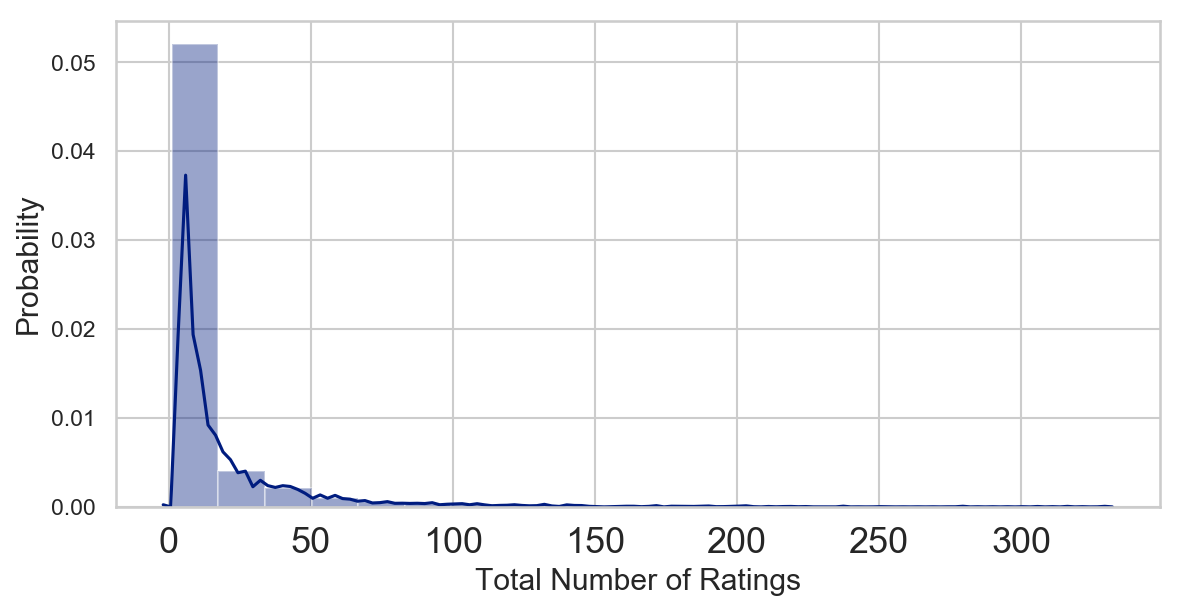

In [96]:
 plt.figure(figsize=(8,4))
sns.distplot(df_n_ratings['total ratings'], bins=20)
plt.xlabel('Total Number of Ratings')
plt.ylabel('Probability')
plt.show()

 ### Highly Rated Movies

In [97]:
df_n_ratings.sort_values('mean ratings', ascending=False).head(10)

,mean ratings,total ratings
title,,
Gena the Crocodile (1969),5.0,1
True Stories (1986),5.0,1
Cosmic Scrat-tastrophe (2015),5.0,1
Love and Pigeons (1985),5.0,1
Red Sorghum (Hong gao liang) (1987),5.0,1
"Thin Line Between Love and Hate, A (1996)",5.0,1
Lesson Faust (1994),5.0,2
Eva (2011),5.0,1
Who Killed Chea Vichea? (2010),5.0,1


In [98]:
print('Total no of users that gave rating of 5.0 : ', len(df_n_ratings.loc[df_n_ratings['mean ratings'] == 5]), '\n')
print('Total no of Individual users that gave rating of 5.0 : ', len(df_n_ratings.loc[(df_n_ratings['mean ratings'] == 5) 
                                                                           & (df_n_ratings['total ratings'] == 1)]))

Total no of users that gave rating of 5.0 :  296 

Total no of Individual users that gave rating of 5.0 :  289


1) As you can see there are over 296 users that have rated 5 stars, among which there are 289 individual raters ( only user to rate the movie 5 star ).

2) So, this cannot be the lone factor that should be considered while recommending movies. As this factor only shows the preferences of a particular user.

3) It would make a good recommendation system if we can use both the factors ( -> Highly Rated Movies and Heavily Rated Movies <- ) together.

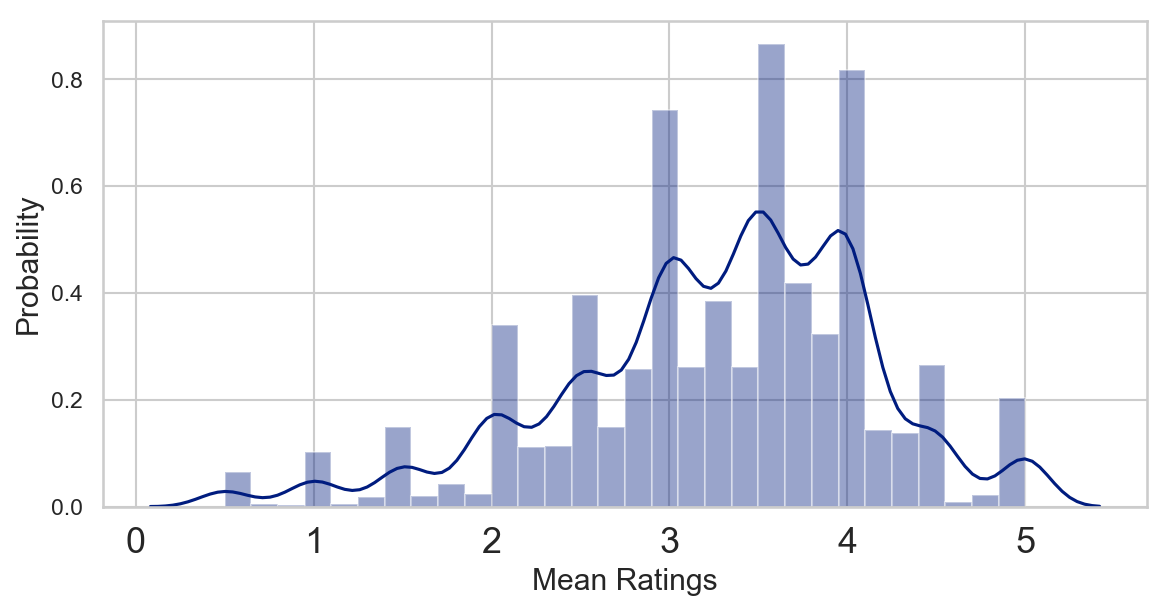

In [99]:
plt.figure(figsize=(8,4))
sns.distplot(df_n_ratings['mean ratings'], bins=30)
plt.xlabel('Mean Ratings')
plt.ylabel('Probability')
plt.show()

####  Mean Ratings vs Total Number of Ratings

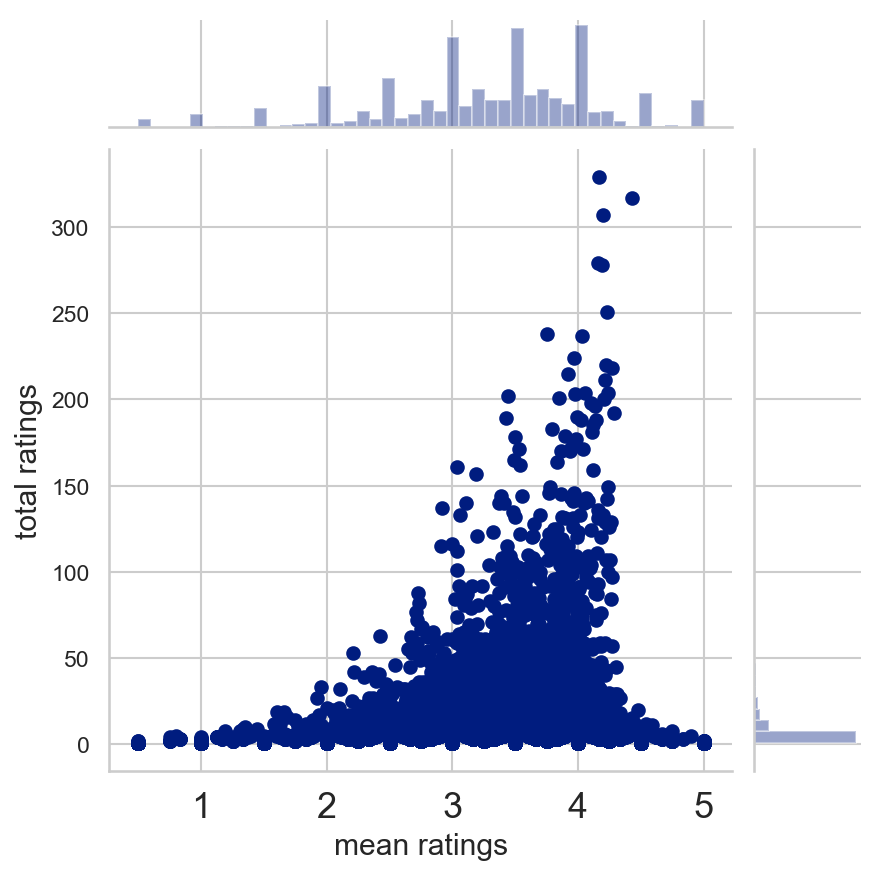

In [100]:
sns.jointplot(x = 'mean ratings', y = 'total ratings', data = df_n_ratings )

1)Here, as you can see every Data Point represents a distinct Movie, with y-coordinate representing the total no of users which has rated that movie and x-coordinate representing the mean of all the ratings of the corresponding users.

2)Also you can see that there is a huge Density in the region corresponding to 0-50 no of users and between mean rating 3-4 .

In [102]:
df_final = pd.DataFrame(df_combined)

In [103]:
df_final.head()

,userId,movieId,rating,user,movie,title,genres
0,1,1,4.0,0,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,4,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,6,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,14,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,16,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


### Collaborative Filtering (CF)

Collaborative filtering is the process of filtering for information or patterns using techniques involving collaboration among multiple agents, viewpoints, data sources.Basically, it is a method of making automatic predictions (filtering) about the interests of a user by collecting preferences or taste information from many users.

There are 2 approaches to CF -->


1) Memory-Based CF - It is an approach which finds similarity between users or between items to recommend similar items. Examples include Neighbourhood-based CF and Item-based/User-based top-N recommendations.


2) Model-Based CF - In this approach we use different data mining, machine learning algorithms to predict users' rating of unrated items. Examples include Singular Value Decomposition (SVD) , Principal Component Analysis (PCA) etc.

### 1) Create User-Item Matrix


In [104]:
util_mat = df_combined.pivot_table(index = 'userId', columns = 'title', values = 'rating')
util_mat.head(20)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


### 2) Memory Based Collaborative Filtering
There are 2 approaches to Memory-Based CF -->

1) User-User Collaborative Filtering - In this we we calculate similarity of all the users to the active user ( the user whom the prediction is for ).Then sort and filter the Top-N users to make predictions for the active user. This is usually very effective but takes a lot of time and resources. For example if Dennis and Davis like the same movies and a new movie comes out that Davis likes,then we can recommend that movie to Dennis because Davis and Dennis seem to like the same movies.

2) Item-Item Collaborative Filtering - This is similar to User-User CF, just that we now compute similarity between items to recommend similar items. Eg. When you buy any product on Amazon, you will find this line "Users who bought this item also bought...", so Amazon uses item-item CF widely, Mind that I'm not saying they use only item-item CF, they have hybrid techniques to better suit users of even unique interests.

Item-Item CF are a lot faster than User-User CF. and secondly user profiles changes quickly and the entire system model has to be recomputed, whereas item's average ratings doesn't change that quickly, and this leads to more stable rating distributions in the model, so the model doesn't have to be rebuilt as often.

#### User based Collaborative Filtering

In [105]:
user_util_matrix = util_mat.copy()

# We will fill the row wise NaN's with the corresponding user's mean ratings, so that we can carry out Pearson correlation.
# Here we assume avg ratings for the movie that is not rated.
user_util_matrix = user_util_matrix.apply(lambda row: row.fillna(row.mean()), axis=1)
user_util_matrix.head(5)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,...,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.000000,4.366379
2,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,...,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276
3,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,...,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897
4,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,...,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556
5,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,...,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364


In [106]:
user_util_matrix.T.corr()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,1.264517e-03,5.525789e-04,0.048419,2.184658e-02,-0.045497,-6.199668e-03,4.701283e-02,1.950986e-02,-8.754091e-03,...,0.018127,-0.017172,-0.015221,-3.705874e-02,-2.912138e-02,0.012016,0.055261,0.075224,-2.571255e-02,0.010932
2,0.001265,1.000000e+00,-1.043295e-17,-0.017164,2.179572e-02,-0.021051,-1.111357e-02,-4.808546e-02,-1.350077e-17,3.011628e-03,...,-0.050551,-0.031581,-0.001688,1.036375e-17,1.265390e-17,0.006226,-0.020504,-0.006001,-6.009099e-02,0.024999
3,0.000553,-1.043295e-17,1.000000e+00,-0.011260,-3.153892e-02,0.004800,1.866590e-17,-3.247105e-02,-8.931480e-18,-1.650113e-17,...,-0.004904,-0.016117,0.017749,6.856184e-18,-1.430628e-03,-0.037289,-0.007789,-0.013001,2.822380e-17,0.019550
4,0.048419,-1.716402e-02,-1.125978e-02,1.000000,-2.962008e-02,0.013956,5.809139e-02,2.064951e-03,-5.873604e-03,5.159032e-02,...,-0.037687,0.063122,0.027640,-1.378212e-02,4.003747e-02,0.020590,0.014628,-0.037569,-1.788358e-02,-0.000995
5,0.021847,2.179572e-02,-3.153892e-02,-0.029620,1.000000e+00,0.009111,1.011714e-02,-1.228358e-02,2.531827e-17,-3.316512e-02,...,0.015964,0.012427,0.027076,1.246135e-02,-3.627207e-02,0.026319,0.031896,-0.001751,9.382890e-02,-0.000278
6,-0.045497,-2.105128e-02,4.799948e-03,0.013956,9.111274e-03,1.000000,4.708604e-03,-7.588790e-02,-2.586745e-05,2.366073e-02,...,-0.015571,-0.002229,-0.014805,-3.356397e-02,1.681540e-02,-0.009137,0.045501,0.021727,5.301726e-02,0.009603
7,-0.006200,-1.111357e-02,1.866590e-17,0.058091,1.011714e-02,0.004709,1.000000e+00,3.109777e-02,6.434956e-02,-2.384936e-02,...,-0.037080,0.050746,0.036846,2.024890e-02,1.086215e-01,0.028326,0.030981,0.028414,8.754383e-03,0.068430
8,0.047013,-4.808546e-02,-3.247105e-02,0.002065,-1.228358e-02,-0.075888,3.109777e-02,1.000000e+00,1.246740e-17,-1.339030e-02,...,0.075826,0.125282,0.025362,1.894854e-01,-2.122042e-02,0.022277,0.048822,0.071759,7.718046e-02,0.017144
9,0.019510,-1.350077e-17,-8.931480e-18,-0.005874,2.531827e-17,-0.000026,6.434956e-02,1.246740e-17,1.000000e+00,2.120696e-02,...,0.024267,0.001060,0.008300,6.073346e-03,7.340770e-02,0.031633,-0.012161,0.032783,3.652303e-17,0.051898


In [107]:
user_corr_mat = user_util_matrix.T.corr()
corr_user_1 = user_corr_mat.iloc[0]

In [108]:
#For convinience, I will be be considering only the correlation of all users with the first user on
corr_user_1.sort_values(ascending=False, inplace=True)

In [109]:
corr_user_1

userId
1      1.000000
301    0.124799
597    0.102631
414    0.101348
477    0.099217
57     0.099070
369    0.098295
206    0.096852
535    0.096493
590    0.095191
418    0.094153
120    0.092770
75     0.091987
577    0.089396
198    0.088883
160    0.088133
226    0.088068
266    0.086064
312    0.086017
19     0.085249
135    0.084672
484    0.084350
469    0.084184
72     0.083613
593    0.082403
44     0.081400
297    0.080839
434    0.078361
483    0.078085
449    0.077631
         ...   
243   -0.043482
363   -0.043838
94    -0.044296
6     -0.045497
361   -0.045970
134   -0.046780
230   -0.047011
541   -0.047762
321   -0.048953
37    -0.049349
569   -0.049434
98    -0.052508
11    -0.056206
402   -0.057089
284   -0.058938
589   -0.059246
592   -0.059507
486   -0.068572
411   -0.068986
329   -0.071189
203   -0.071565
39    -0.072666
102   -0.074549
557   -0.074859
395   -0.075800
71    -0.082932
370   -0.086678
501   -0.090018
579   -0.105003
53          NaN
Name: 1, Length: 

In [110]:
# NaN values are generated in corr() as the std dev is zero, which is required in calculating Pearson Similarity.
corr_user_1.dropna(inplace = True)

In [111]:
# Neglect the 1st corr value as it is user1 itself
top50_corr_users = corr_user_1[1:51]

#### Below, we have list of all movies that user 1 has ever watched.

In [113]:
df_final[ df_final['userId'] == 1]

,userId,movieId,rating,user,movie,title,genres
0,1,1,4.0,0,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
215,1,3,4.0,0,2,Grumpier Old Men (1995),Comedy|Romance
267,1,6,4.0,0,5,Heat (1995),Action|Crime|Thriller
369,1,47,5.0,0,43,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
572,1,50,5.0,0,46,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
776,1,70,3.0,0,62,From Dusk Till Dawn (1996),Action|Comedy|Horror|Thriller
831,1,101,5.0,0,89,Bottle Rocket (1996),Adventure|Comedy|Crime|Romance
854,1,110,4.0,0,97,Braveheart (1995),Action|Drama|War
1091,1,151,5.0,0,124,Rob Roy (1995),Action|Drama|Romance|War
1135,1,157,5.0,0,130,Canadian Bacon (1995),Comedy|War


In [114]:

# user1 has not watched 32 movie
df_final[ (df_final['userId'] == 1) & (df_final['movieId'] == 32) ]

,userId,movieId,rating,user,movie,title,genres


In [115]:
print('32nd Movie : ', movies['title'][ movies['movieId'] == 32 ].values)

32nd Movie :  ['Twelve Monkeys (a.k.a. 12 Monkeys) (1995)']


In [116]:

df_n_ratings.loc[['Twelve Monkeys (a.k.a. 12 Monkeys) (1995)']]

,mean ratings,total ratings
title,,
Twelve Monkeys (a.k.a. 12 Monkeys) (1995),3.983051,177


### 3) Item Based Collaborative Filtering¶


In [117]:
# Let's find similar movies to jurassic Park
df_n_ratings.loc[['Jurassic Park (1993)']]

,mean ratings,total ratings
title,,
Jurassic Park (1993),3.75,238


In [118]:
item_util_matrix = util_mat.copy()
item_util_matrix.head(10)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In [119]:

# We will fill the column wise NaN's with the corresponding movie's mean ratings, so that we can carry out Pearson correlation.
# Here we assume avg ratings for the user that has not a rated movie.

item_util_matrix = item_util_matrix.apply(lambda col : col.fillna(col.mean()), axis=0)
item_util_matrix.head(5)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,4.0,3.5,5.0,4.0,1.5,3.176471,3.0,3.666667,3.285714,...,1.5,4.0625,3.666667,3.0,3.0,3.863636,2.770833,2.0,4.000000,1.0
2,4.0,4.0,3.5,5.0,4.0,1.5,3.176471,3.0,3.666667,3.285714,...,1.5,4.0625,3.666667,3.0,3.0,3.863636,2.770833,2.0,3.134615,1.0
3,4.0,4.0,3.5,5.0,4.0,1.5,3.176471,3.0,3.666667,3.285714,...,1.5,4.0625,3.666667,3.0,3.0,3.863636,2.770833,2.0,3.134615,1.0
4,4.0,4.0,3.5,5.0,4.0,1.5,3.176471,3.0,3.666667,3.285714,...,1.5,4.0625,3.666667,3.0,3.0,3.863636,2.770833,2.0,3.134615,1.0
5,4.0,4.0,3.5,5.0,4.0,1.5,3.176471,3.0,3.666667,3.285714,...,1.5,4.0625,3.666667,3.0,3.0,3.863636,2.770833,2.0,3.134615,1.0


In [120]:
item_util_matrix.isna().sum().sum()

0

#### This signifies that every Movie is watched  by atleast 1 user

In [121]:
item_util_matrix.corr()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Hellboy': The Seeds of Creation (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Round Midnight (1986),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Salem's Lot (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Til There Was You (1997),NaN,NaN,NaN,NaN,1.000000,NaN,0.000000e+00,NaN,0.000000e+00,0.000000e+00,...,NaN,0.000000,0.000000e+00,NaN,NaN,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,NaN
'Tis the Season for Love (2015),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"'burbs, The (1989)",NaN,NaN,NaN,NaN,0.000000,NaN,1.000000e+00,NaN,5.210830e-02,8.030237e-02,...,NaN,0.000000,8.720166e-17,NaN,NaN,6.069908e-02,-3.527098e-03,0.000000,1.683581e-02,NaN
'night Mother (1986),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
(500) Days of Summer (2009),NaN,NaN,NaN,NaN,0.000000,NaN,5.210830e-02,NaN,1.000000e+00,2.721766e-01,...,NaN,-0.091372,3.798690e-03,NaN,NaN,-7.527709e-02,1.558884e-01,0.110782,4.333034e-02,NaN



### 4) Model Based Collaborative Filtering

Here we will be using dimensionality reduction methods to improve robustness and accuracy of Memory-Based CF. Basically, we compress user-item matrix into a low dimension matrix. We use techniques like SVD which is a low-rank factorization method, PCA which is used for dimensionaliry reduction etc.

Model-based methods are based on matrix factorization and are better at dealing with sparsity.

We will be using a "Surprise" library to implement SVD, KNN and NMF.

Surprise Library has almost all the algorithms implemented that are required for model-based Recommendation systems.

In [122]:

from surprise import Reader, Dataset, KNNBasic, SVD, NMF
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate

In [123]:
reader = Reader(rating_scale=(0.5, 5.0))

data = Dataset.load_from_df( ratings[['userId', 'movieId', 'rating']], reader = reader )

###  K-Nearest Neighbours (KNN)

In [125]:
# Compute Mean Squared Distance Similarity
sim_options = {'name' : 'msd'}

algo = KNNBasic(k=20, sim_options=sim_options )
cross_validate(algo=algo, data=data, measures=['RMSE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9387  0.9442  0.9363  0.9512  0.9374  0.9416  0.0055  
Fit time          0.56    0.58    0.58    0.63    0.50    0.57    0.04    
Test time         3.09    2.86    2.28    2.70    2.95    2.78    0.28    


{'test_rmse': array([0.93872198, 0.94422124, 0.93632892, 0.95117772, 0.93742071]),
 'fit_time': (0.5581068992614746,
  0.5774505138397217,
  0.5842089653015137,
  0.6256253719329834,
  0.4992945194244385),
 'test_time': (3.085578441619873,
  2.8617889881134033,
  2.2848870754241943,
  2.704678535461426,
  2.947974443435669)}

#### Tuning KNN using GridSearchCV

In [126]:
n_neighbours = [10, 20, 30]
param_grid = {'n_neighbours' : n_neighbours}

gs = GridSearchCV(KNNBasic, measures=['RMSE'], param_grid=param_grid)
gs.fit(data)

print('\n\n###############')
# Best RMSE score
print('Best Score :', gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print('Best Parameters :', gs.best_params['rmse'])
print('###############')

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

####  Singular Value Decomposition (SVD)

In [128]:
algo = SVD()
cross_validate(algo=algo, data=data, measures=['RMSE'], cv=5, verbose=True)


Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8809  0.8709  0.8731  0.8751  0.8699  0.8740  0.0039  
Fit time          10.54   10.77   10.56   11.13   10.04   10.61   0.36    
Test time         0.82    0.23    0.28    0.27    0.26    0.37    0.23    


{'test_rmse': array([0.88093852, 0.87089849, 0.87307905, 0.87512671, 0.86988874]),
 'fit_time': (10.543394565582275,
  10.767177104949951,
  10.560624361038208,
  11.134378433227539,
  10.038987874984741),
 'test_time': (0.8243615627288818,
  0.23439407348632812,
  0.28127408027648926,
  0.2678408622741699,
  0.26340413093566895)}

#### Fine Tuning SVD using GridSearchCV

In [129]:
param_grid = {'n_factors' : [50, 75], 'lr_all' : [0.5, 0.05], 'reg_all' : [0.06, 0.04]}

gs = GridSearchCV(algo_class=SVD, measures=['RMSE'], param_grid=param_grid)
gs.fit(data)

print('\n###############')
# Best RMSE score
print('Best Score :', gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print('Best Parameters :', gs.best_params['rmse'])
print('###############')


###############
Best Score : 0.8648120453044049
Best Parameters : {'n_factors': 75, 'lr_all': 0.05, 'reg_all': 0.06}
###############


### Non-Negative Matrix Factorization (NMF)


In [132]:

algo = NMF()
cross_validate(data=data, algo=algo, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9209  0.9343  0.9208  0.9191  0.9136  0.9217  0.0068  
Fit time          9.18    9.60    9.02    9.66    9.06    9.30    0.27    
Test time         0.22    0.20    0.19    0.20    0.20    0.20    0.01    


{'test_rmse': array([0.92085181, 0.93426075, 0.92083753, 0.91912655, 0.91360565]),
 'fit_time': (9.178545236587524,
  9.598467111587524,
  9.016330480575562,
  9.661680459976196,
  9.064125537872314),
 'test_time': (0.21876811981201172,
  0.2031421661376953,
  0.18751764297485352,
  0.203141450881958,
  0.20313811302185059)}

### Recommender System  using  Neural Nets (Keras)

In [15]:
X = ratings[['user', 'movie']].values
y = ratings['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((90752, 2), (10084, 2), (90752,), (10084,))

In [62]:
n_factors = 50
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [32]:
from keras.layers import Add, Activation, Lambda
class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        return x
def RecommenderV2(n_users, n_movies, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    ub = EmbeddingLayer(n_users, 1)(user)
    
    movie = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, n_factors)(movie)
    mb = EmbeddingLayer(n_movies, 1)(movie)
    x = Dot(axes=1)([u, m])
    x = Add()([x, ub, mb])
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

In [33]:
model = RecommenderV2(n_users, n_movies, n_factors, min_rating, max_rating)
model.summary()


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 1, 50)        30500       input_9[0][0]                    
__________________________________________________________________________________________________
embedding_15 (Embedding)        (None, 1, 50)        486200      input_10[0][0]                   
____________________________________________________________________________________________

In [34]:
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=5,
                    verbose=1, validation_data=(X_test_array, y_test))

C:\Users\amreen\newpy\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 90752 samples, validate on 10084 samples
Epoch 1/5
90752/90752 [==============================] - 70s 767us/step - loss: 1.1975 - val_loss: 0.8544
Epoch 2/5
90752/90752 [==============================] - 82s 907us/step - loss: 0.6972 - val_loss: 0.7521
Epoch 3/5
90752/90752 [==============================] - 73s 803us/step - loss: 0.5273 - val_loss: 0.7347
Epoch 4/5
90752/90752 [==============================] - 69s 761us/step - loss: 0.4019 - val_loss: 0.7411
Epoch 5/5
90752/90752 [==============================] - 74s 812us/step - loss: 0.3102 - val_loss: 0.7530


In [41]:
from keras.layers import Concatenate, Dense, Dropout
def RecommenderNet(n_users, n_movies, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    
    movie = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, n_factors)(movie)
    
    x = Concatenate()([u, m])
    x = Dropout(0.05)(x)
    
    x = Dense(10, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

In [42]:
model = RecommenderNet(n_users, n_movies, n_factors, min_rating, max_rating)
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_21 (Embedding)        (None, 1, 50)        30500       input_15[0][0]                   
__________________________________________________________________________________________________
embedding_22 (Embedding)        (None, 1, 50)        486200      input_16[0][0]                   
____________________________________________________________________________________________

In [60]:
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=5,
                    verbose=1, validation_data=(X_test_array, y_test))

Train on 90752 samples, validate on 10084 samples
Epoch 1/5
90752/90752 [==============================] - 65s 715us/step - loss: 0.7280 - val_loss: 0.7867
Epoch 2/5
90752/90752 [==============================] - 61s 668us/step - loss: 0.7238 - val_loss: 0.7880
Epoch 3/5
90752/90752 [==============================] - 51s 561us/step - loss: 0.7168 - val_loss: 0.7833
Epoch 4/5
90752/90752 [==============================] - 54s 596us/step - loss: 0.7166 - val_loss: 0.7859
Epoch 5/5
90752/90752 [==============================] - 53s 580us/step - loss: 0.7131 - val_loss: 0.7890


In [61]:
score = model.evaluate(X_test_array, y_test)

print()
print('RMSE: {:.4f}'.format(np.sqrt(score)))

10084/10084 [==============================] - 3s 300us/step

RMSE: 0.8882


### **Thank you**